### Importing Modules

In [1]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset,random_split
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
from torchvision.datasets import CIFAR100
import os

### Setting the hyperparameters

In [2]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 60
LEARNING_RATE = 1e-4
NUM_CLASSES = 100 
PATCH_SIZE = 4
IMG_SIZE = 32  
IN_CHANNELS = 3  
NUM_HEADS = 8
DROPOUT = 0.4
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS  
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2  

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

### Patch Embedding with position embedding

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)  
        self.position_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        batch_size = x.shape[0]
        cls_token = self.cls_token.expand(batch_size, -1, -1) 

        x = self.patcher(x).permute(0, 2, 1)  
        x = torch.cat([cls_token, x], dim=1)  
        x = self.position_embeddings + x  
        x = self.dropout(x)
        return x


model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)


x = torch.randn(512, 3, 32, 32).to(device) 
print(model(x).shape)  

torch.Size([512, 65, 48])


### VIT implementation with encoder and MLP

In [4]:
class ViT(nn.Module):
    def __init__(self, num_patches, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True
        )
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :]) 
        return x


model = ViT(NUM_PATCHES, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)


x = torch.randn(512, 3, 32, 32).to(device) 
print(model(x).shape)  

torch.Size([512, 100])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


### Dataset Preparation

In [5]:

extract_path = "/kaggle/input/ciphar-100"


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])


train_dataset = datasets.CIFAR100(root=extract_path, train=True, transform=transform, download=False)
test_dataset = datasets.CIFAR100(root=extract_path, train=False, transform=transform, download=False)


train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("Dataset successfully loaded!")

Dataset successfully loaded!


### Train Dataset

In [6]:
class CIFAR100TrainDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image)
        return {"image": image, "label": label, "index": idx}

class CIFAR100ValDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image)
        return {"image": image, "label": label, "index": idx}

class CIFAR100TestDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  
        image = self.transform(image)
        return {"image": image, "index": idx}

### Train Data Plot

<Figure size 1000x500 with 0 Axes>

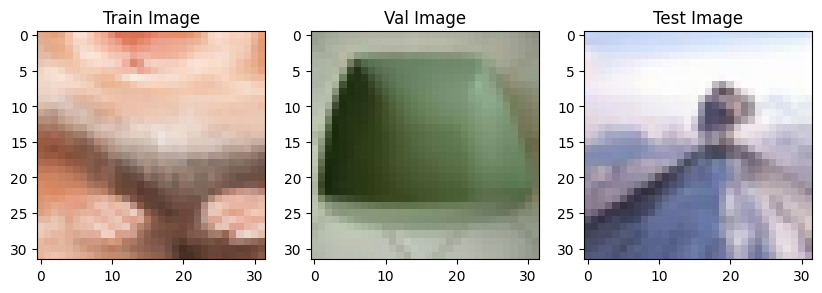

In [7]:

train_idx = train_dataset.indices[0] if hasattr(train_dataset, 'indices') else 0
val_idx = val_dataset.indices[0] if hasattr(val_dataset, 'indices') else 0

train_sample, _ = train_dataset.dataset[train_idx]  
val_sample, _ = val_dataset.dataset[val_idx]
test_sample, _ = test_dataset[0]  


train_sample = train_sample.permute(1, 2, 0).numpy()
val_sample = val_sample.permute(1, 2, 0).numpy()
test_sample = test_sample.permute(1, 2, 0).numpy()

mean = np.array([0.5071, 0.4867, 0.4408])
std = np.array([0.2675, 0.2565, 0.2761])

train_sample = (train_sample * std + mean).clip(0, 1)
val_sample = (val_sample * std + mean).clip(0, 1)
test_sample = (test_sample * std + mean).clip(0, 1)

plt.figure(figsize=(10, 5))
f, axarr = plt.subplots(1, 3, figsize=(10, 5))

axarr[0].imshow(train_sample)
axarr[0].set_title("Train Image")

axarr[1].imshow(val_sample)
axarr[1].set_title("Val Image")

axarr[2].imshow(test_sample)
axarr[2].set_title("Test Image")

plt.show()

### Training the model

In [8]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()

for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_correct, train_total, train_running_loss = 0, 0, 0

    for idx, (img, label) in enumerate(tqdm(train_loader, position=0, leave=True)):
        img, label = img.to(device), label.to(device, dtype=torch.long)   

        y_pred = model(img)
        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

       
        y_pred_label = torch.argmax(y_pred, dim=1)
        train_correct += (y_pred_label == label).sum().item()
        train_total += label.size(0)

    train_loss = train_running_loss / (idx + 1)
    train_accuracy = train_correct / train_total

    
    model.eval()
    val_correct, val_total, val_running_loss = 0, 0, 0

    with torch.no_grad():
        for idx, (img, label) in enumerate(tqdm(val_loader, position=0, leave=True)):
            img, label = img.to(device), label.to(device, dtype=torch.long)

            y_pred = model(img)
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()

            
            y_pred_label = torch.argmax(y_pred, dim=1)
            val_correct += (y_pred_label == label).sum().item()
            val_total += label.size(0)

    val_loss = val_running_loss / (idx + 1)
    val_accuracy = val_correct / val_total

    print("-" * 30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {train_accuracy:.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {val_accuracy:.4f}")
    print("-" * 30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  2%|▏         | 1/60 [00:12<12:24, 12.62s/it]

------------------------------
Train Loss EPOCH 1: 4.6822
Valid Loss EPOCH 1: 4.6007
Train Accuracy EPOCH 1: 0.0101
Valid Accuracy EPOCH 1: 0.0136
------------------------------


  3%|▎         | 2/60 [00:24<11:56, 12.36s/it]

------------------------------
Train Loss EPOCH 2: 4.6093
Valid Loss EPOCH 2: 4.5486
Train Accuracy EPOCH 2: 0.0149
Valid Accuracy EPOCH 2: 0.0250
------------------------------


  5%|▌         | 3/60 [00:36<11:40, 12.28s/it]

------------------------------
Train Loss EPOCH 3: 4.5505
Valid Loss EPOCH 3: 4.4707
Train Accuracy EPOCH 3: 0.0200
Valid Accuracy EPOCH 3: 0.0260
------------------------------


  7%|▋         | 4/60 [00:49<11:27, 12.28s/it]

------------------------------
Train Loss EPOCH 4: 4.4743
Valid Loss EPOCH 4: 4.4048
Train Accuracy EPOCH 4: 0.0282
Valid Accuracy EPOCH 4: 0.0352
------------------------------


  8%|▊         | 5/60 [01:01<11:16, 12.29s/it]

------------------------------
Train Loss EPOCH 5: 4.4187
Valid Loss EPOCH 5: 4.3594
Train Accuracy EPOCH 5: 0.0309
Valid Accuracy EPOCH 5: 0.0376
------------------------------


 10%|█         | 6/60 [01:13<11:03, 12.29s/it]

------------------------------
Train Loss EPOCH 6: 4.3795
Valid Loss EPOCH 6: 4.3256
Train Accuracy EPOCH 6: 0.0339
Valid Accuracy EPOCH 6: 0.0418
------------------------------


 12%|█▏        | 7/60 [01:26<10:52, 12.32s/it]

------------------------------
Train Loss EPOCH 7: 4.3486
Valid Loss EPOCH 7: 4.2969
Train Accuracy EPOCH 7: 0.0355
Valid Accuracy EPOCH 7: 0.0442
------------------------------


 13%|█▎        | 8/60 [01:38<10:39, 12.30s/it]

------------------------------
Train Loss EPOCH 8: 4.3209
Valid Loss EPOCH 8: 4.2635
Train Accuracy EPOCH 8: 0.0397
Valid Accuracy EPOCH 8: 0.0440
------------------------------


 15%|█▌        | 9/60 [01:50<10:27, 12.30s/it]

------------------------------
Train Loss EPOCH 9: 4.2944
Valid Loss EPOCH 9: 4.2433
Train Accuracy EPOCH 9: 0.0417
Valid Accuracy EPOCH 9: 0.0456
------------------------------


 17%|█▋        | 10/60 [02:03<10:15, 12.31s/it]

------------------------------
Train Loss EPOCH 10: 4.2711
Valid Loss EPOCH 10: 4.2078
Train Accuracy EPOCH 10: 0.0440
Valid Accuracy EPOCH 10: 0.0474
------------------------------


 18%|█▊        | 11/60 [02:15<10:02, 12.29s/it]

------------------------------
Train Loss EPOCH 11: 4.2446
Valid Loss EPOCH 11: 4.1805
Train Accuracy EPOCH 11: 0.0460
Valid Accuracy EPOCH 11: 0.0516
------------------------------


 20%|██        | 12/60 [02:27<09:49, 12.29s/it]

------------------------------
Train Loss EPOCH 12: 4.2184
Valid Loss EPOCH 12: 4.1506
Train Accuracy EPOCH 12: 0.0493
Valid Accuracy EPOCH 12: 0.0540
------------------------------


 22%|██▏       | 13/60 [02:39<09:36, 12.27s/it]

------------------------------
Train Loss EPOCH 13: 4.1917
Valid Loss EPOCH 13: 4.1199
Train Accuracy EPOCH 13: 0.0522
Valid Accuracy EPOCH 13: 0.0596
------------------------------


 23%|██▎       | 14/60 [02:52<09:25, 12.29s/it]

------------------------------
Train Loss EPOCH 14: 4.1624
Valid Loss EPOCH 14: 4.0969
Train Accuracy EPOCH 14: 0.0573
Valid Accuracy EPOCH 14: 0.0642
------------------------------


 25%|██▌       | 15/60 [03:04<09:13, 12.30s/it]

------------------------------
Train Loss EPOCH 15: 4.1312
Valid Loss EPOCH 15: 4.0713
Train Accuracy EPOCH 15: 0.0606
Valid Accuracy EPOCH 15: 0.0706
------------------------------


 27%|██▋       | 16/60 [03:16<09:00, 12.29s/it]

------------------------------
Train Loss EPOCH 16: 4.1004
Valid Loss EPOCH 16: 4.0274
Train Accuracy EPOCH 16: 0.0653
Valid Accuracy EPOCH 16: 0.0752
------------------------------


 28%|██▊       | 17/60 [03:29<08:49, 12.30s/it]

------------------------------
Train Loss EPOCH 17: 4.0686
Valid Loss EPOCH 17: 4.0287
Train Accuracy EPOCH 17: 0.0694
Valid Accuracy EPOCH 17: 0.0730
------------------------------


 30%|███       | 18/60 [03:41<08:37, 12.32s/it]

------------------------------
Train Loss EPOCH 18: 4.0443
Valid Loss EPOCH 18: 3.9947
Train Accuracy EPOCH 18: 0.0735
Valid Accuracy EPOCH 18: 0.0776
------------------------------


 32%|███▏      | 19/60 [03:53<08:24, 12.32s/it]

------------------------------
Train Loss EPOCH 19: 4.0178
Valid Loss EPOCH 19: 4.0016
Train Accuracy EPOCH 19: 0.0754
Valid Accuracy EPOCH 19: 0.0764
------------------------------


 33%|███▎      | 20/60 [04:06<08:14, 12.36s/it]

------------------------------
Train Loss EPOCH 20: 3.9989
Valid Loss EPOCH 20: 3.9820
Train Accuracy EPOCH 20: 0.0778
Valid Accuracy EPOCH 20: 0.0784
------------------------------


 35%|███▌      | 21/60 [04:18<08:01, 12.34s/it]

------------------------------
Train Loss EPOCH 21: 3.9813
Valid Loss EPOCH 21: 3.9718
Train Accuracy EPOCH 21: 0.0807
Valid Accuracy EPOCH 21: 0.0808
------------------------------


 37%|███▋      | 22/60 [04:30<07:49, 12.35s/it]

------------------------------
Train Loss EPOCH 22: 3.9676
Valid Loss EPOCH 22: 3.9570
Train Accuracy EPOCH 22: 0.0834
Valid Accuracy EPOCH 22: 0.0812
------------------------------


 38%|███▊      | 23/60 [04:43<07:37, 12.36s/it]

------------------------------
Train Loss EPOCH 23: 3.9533
Valid Loss EPOCH 23: 3.9327
Train Accuracy EPOCH 23: 0.0851
Valid Accuracy EPOCH 23: 0.0890
------------------------------


 40%|████      | 24/60 [04:55<07:24, 12.35s/it]

------------------------------
Train Loss EPOCH 24: 3.9367
Valid Loss EPOCH 24: 3.9412
Train Accuracy EPOCH 24: 0.0871
Valid Accuracy EPOCH 24: 0.0868
------------------------------


 42%|████▏     | 25/60 [05:08<07:12, 12.35s/it]

------------------------------
Train Loss EPOCH 25: 3.9209
Valid Loss EPOCH 25: 3.9092
Train Accuracy EPOCH 25: 0.0893
Valid Accuracy EPOCH 25: 0.0898
------------------------------


 43%|████▎     | 26/60 [05:20<06:59, 12.34s/it]

------------------------------
Train Loss EPOCH 26: 3.9093
Valid Loss EPOCH 26: 3.9382
Train Accuracy EPOCH 26: 0.0914
Valid Accuracy EPOCH 26: 0.0856
------------------------------


 45%|████▌     | 27/60 [05:32<06:46, 12.33s/it]

------------------------------
Train Loss EPOCH 27: 3.8987
Valid Loss EPOCH 27: 3.9526
Train Accuracy EPOCH 27: 0.0912
Valid Accuracy EPOCH 27: 0.0868
------------------------------


 47%|████▋     | 28/60 [05:44<06:33, 12.30s/it]

------------------------------
Train Loss EPOCH 28: 3.8874
Valid Loss EPOCH 28: 3.9284
Train Accuracy EPOCH 28: 0.0931
Valid Accuracy EPOCH 28: 0.0926
------------------------------


 48%|████▊     | 29/60 [05:57<06:20, 12.27s/it]

------------------------------
Train Loss EPOCH 29: 3.8754
Valid Loss EPOCH 29: 3.8857
Train Accuracy EPOCH 29: 0.0949
Valid Accuracy EPOCH 29: 0.0948
------------------------------


 50%|█████     | 30/60 [06:09<06:08, 12.28s/it]

------------------------------
Train Loss EPOCH 30: 3.8657
Valid Loss EPOCH 30: 3.8987
Train Accuracy EPOCH 30: 0.0944
Valid Accuracy EPOCH 30: 0.0950
------------------------------


 52%|█████▏    | 31/60 [06:21<05:56, 12.30s/it]

------------------------------
Train Loss EPOCH 31: 3.8534
Valid Loss EPOCH 31: 3.9062
Train Accuracy EPOCH 31: 0.0979
Valid Accuracy EPOCH 31: 0.0974
------------------------------


 53%|█████▎    | 32/60 [06:34<05:44, 12.30s/it]

------------------------------
Train Loss EPOCH 32: 3.8482
Valid Loss EPOCH 32: 3.8627
Train Accuracy EPOCH 32: 0.0995
Valid Accuracy EPOCH 32: 0.0998
------------------------------


 55%|█████▌    | 33/60 [06:46<05:32, 12.31s/it]

------------------------------
Train Loss EPOCH 33: 3.8314
Valid Loss EPOCH 33: 3.8384
Train Accuracy EPOCH 33: 0.1015
Valid Accuracy EPOCH 33: 0.1028
------------------------------


 57%|█████▋    | 34/60 [06:58<05:19, 12.30s/it]

------------------------------
Train Loss EPOCH 34: 3.8254
Valid Loss EPOCH 34: 3.8732
Train Accuracy EPOCH 34: 0.1032
Valid Accuracy EPOCH 34: 0.1024
------------------------------


 58%|█████▊    | 35/60 [07:10<05:07, 12.31s/it]

------------------------------
Train Loss EPOCH 35: 3.8154
Valid Loss EPOCH 35: 3.8448
Train Accuracy EPOCH 35: 0.1037
Valid Accuracy EPOCH 35: 0.1038
------------------------------


 60%|██████    | 36/60 [07:23<04:55, 12.30s/it]

------------------------------
Train Loss EPOCH 36: 3.8031
Valid Loss EPOCH 36: 3.8174
Train Accuracy EPOCH 36: 0.1059
Valid Accuracy EPOCH 36: 0.1072
------------------------------


 62%|██████▏   | 37/60 [07:35<04:42, 12.29s/it]

------------------------------
Train Loss EPOCH 37: 3.7956
Valid Loss EPOCH 37: 3.8126
Train Accuracy EPOCH 37: 0.1067
Valid Accuracy EPOCH 37: 0.1052
------------------------------


 63%|██████▎   | 38/60 [07:47<04:30, 12.30s/it]

------------------------------
Train Loss EPOCH 38: 3.7824
Valid Loss EPOCH 38: 3.7992
Train Accuracy EPOCH 38: 0.1109
Valid Accuracy EPOCH 38: 0.1072
------------------------------


 65%|██████▌   | 39/60 [08:00<04:18, 12.30s/it]

------------------------------
Train Loss EPOCH 39: 3.7730
Valid Loss EPOCH 39: 3.7908
Train Accuracy EPOCH 39: 0.1090
Valid Accuracy EPOCH 39: 0.1090
------------------------------


 67%|██████▋   | 40/60 [08:12<04:05, 12.30s/it]

------------------------------
Train Loss EPOCH 40: 3.7660
Valid Loss EPOCH 40: 3.7938
Train Accuracy EPOCH 40: 0.1134
Valid Accuracy EPOCH 40: 0.1106
------------------------------


 68%|██████▊   | 41/60 [08:24<03:53, 12.28s/it]

------------------------------
Train Loss EPOCH 41: 3.7562
Valid Loss EPOCH 41: 3.7775
Train Accuracy EPOCH 41: 0.1153
Valid Accuracy EPOCH 41: 0.1124
------------------------------


 70%|███████   | 42/60 [08:36<03:41, 12.28s/it]

------------------------------
Train Loss EPOCH 42: 3.7461
Valid Loss EPOCH 42: 3.8067
Train Accuracy EPOCH 42: 0.1128
Valid Accuracy EPOCH 42: 0.1080
------------------------------


 72%|███████▏  | 43/60 [08:49<03:28, 12.29s/it]

------------------------------
Train Loss EPOCH 43: 3.7358
Valid Loss EPOCH 43: 3.7510
Train Accuracy EPOCH 43: 0.1184
Valid Accuracy EPOCH 43: 0.1142
------------------------------


 73%|███████▎  | 44/60 [09:01<03:16, 12.30s/it]

------------------------------
Train Loss EPOCH 44: 3.7269
Valid Loss EPOCH 44: 3.7680
Train Accuracy EPOCH 44: 0.1178
Valid Accuracy EPOCH 44: 0.1144
------------------------------


 75%|███████▌  | 45/60 [09:13<03:04, 12.31s/it]

------------------------------
Train Loss EPOCH 45: 3.7145
Valid Loss EPOCH 45: 3.7348
Train Accuracy EPOCH 45: 0.1212
Valid Accuracy EPOCH 45: 0.1192
------------------------------


 77%|███████▋  | 46/60 [09:26<02:52, 12.33s/it]

------------------------------
Train Loss EPOCH 46: 3.7049
Valid Loss EPOCH 46: 3.7272
Train Accuracy EPOCH 46: 0.1203
Valid Accuracy EPOCH 46: 0.1148
------------------------------


 78%|███████▊  | 47/60 [09:38<02:40, 12.33s/it]

------------------------------
Train Loss EPOCH 47: 3.6988
Valid Loss EPOCH 47: 3.7365
Train Accuracy EPOCH 47: 0.1229
Valid Accuracy EPOCH 47: 0.1182
------------------------------


 80%|████████  | 48/60 [09:50<02:28, 12.34s/it]

------------------------------
Train Loss EPOCH 48: 3.6913
Valid Loss EPOCH 48: 3.7076
Train Accuracy EPOCH 48: 0.1229
Valid Accuracy EPOCH 48: 0.1224
------------------------------


 82%|████████▏ | 49/60 [10:03<02:15, 12.34s/it]

------------------------------
Train Loss EPOCH 49: 3.6856
Valid Loss EPOCH 49: 3.7016
Train Accuracy EPOCH 49: 0.1231
Valid Accuracy EPOCH 49: 0.1220
------------------------------


 83%|████████▎ | 50/60 [10:15<02:03, 12.33s/it]

------------------------------
Train Loss EPOCH 50: 3.6736
Valid Loss EPOCH 50: 3.7128
Train Accuracy EPOCH 50: 0.1282
Valid Accuracy EPOCH 50: 0.1218
------------------------------


 85%|████████▌ | 51/60 [10:27<01:50, 12.32s/it]

------------------------------
Train Loss EPOCH 51: 3.6634
Valid Loss EPOCH 51: 3.6859
Train Accuracy EPOCH 51: 0.1286
Valid Accuracy EPOCH 51: 0.1270
------------------------------


 87%|████████▋ | 52/60 [10:40<01:38, 12.31s/it]

------------------------------
Train Loss EPOCH 52: 3.6548
Valid Loss EPOCH 52: 3.6857
Train Accuracy EPOCH 52: 0.1315
Valid Accuracy EPOCH 52: 0.1258
------------------------------


 88%|████████▊ | 53/60 [10:52<01:26, 12.32s/it]

------------------------------
Train Loss EPOCH 53: 3.6529
Valid Loss EPOCH 53: 3.6981
Train Accuracy EPOCH 53: 0.1278
Valid Accuracy EPOCH 53: 0.1266
------------------------------


 90%|█████████ | 54/60 [11:04<01:13, 12.32s/it]

------------------------------
Train Loss EPOCH 54: 3.6380
Valid Loss EPOCH 54: 3.6981
Train Accuracy EPOCH 54: 0.1328
Valid Accuracy EPOCH 54: 0.1250
------------------------------


 92%|█████████▏| 55/60 [11:17<01:01, 12.31s/it]

------------------------------
Train Loss EPOCH 55: 3.6338
Valid Loss EPOCH 55: 3.6982
Train Accuracy EPOCH 55: 0.1318
Valid Accuracy EPOCH 55: 0.1244
------------------------------


 93%|█████████▎| 56/60 [11:29<00:49, 12.33s/it]

------------------------------
Train Loss EPOCH 56: 3.6209
Valid Loss EPOCH 56: 3.6694
Train Accuracy EPOCH 56: 0.1369
Valid Accuracy EPOCH 56: 0.1286
------------------------------


 95%|█████████▌| 57/60 [11:41<00:36, 12.33s/it]

------------------------------
Train Loss EPOCH 57: 3.6115
Valid Loss EPOCH 57: 3.6718
Train Accuracy EPOCH 57: 0.1354
Valid Accuracy EPOCH 57: 0.1288
------------------------------


 97%|█████████▋| 58/60 [11:54<00:24, 12.35s/it]

------------------------------
Train Loss EPOCH 58: 3.6081
Valid Loss EPOCH 58: 3.6487
Train Accuracy EPOCH 58: 0.1363
Valid Accuracy EPOCH 58: 0.1316
------------------------------


 98%|█████████▊| 59/60 [12:06<00:12, 12.36s/it]

------------------------------
Train Loss EPOCH 59: 3.5963
Valid Loss EPOCH 59: 3.6377
Train Accuracy EPOCH 59: 0.1394
Valid Accuracy EPOCH 59: 0.1350
------------------------------


100%|██████████| 60/60 [12:18<00:00, 12.32s/it]

------------------------------
Train Loss EPOCH 60: 3.5911
Valid Loss EPOCH 60: 3.6424
Train Accuracy EPOCH 60: 0.1405
Valid Accuracy EPOCH 60: 0.1346
------------------------------
Training Time: 738.99s


In [9]:
torch.cuda.empty_cache()

### Evaluation the model

In [10]:
labels = []
imgs = []
model.eval()
with torch.no_grad():
    for img, _ in tqdm(test_loader, position=0, leave=True):  
        img = img.to(device)
        outputs = model(img)

   
        labels.extend(torch.argmax(outputs, dim=1).cpu().tolist())  

100%|██████████| 20/20 [00:01<00:00, 14.56it/s]


<Figure size 640x480 with 0 Axes>

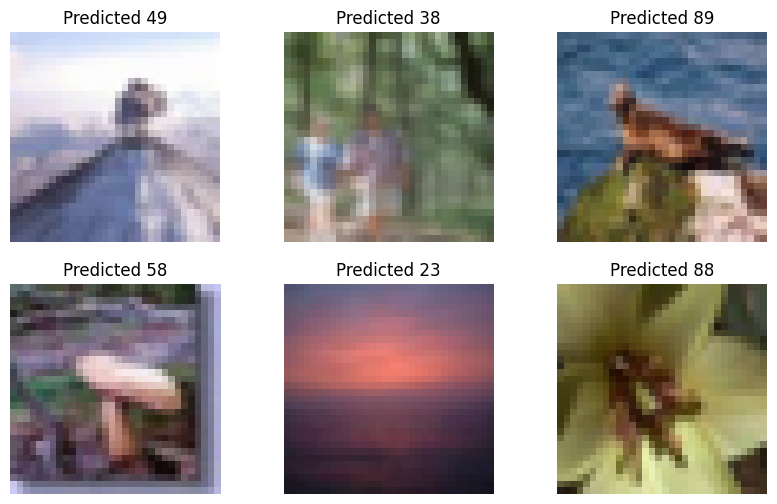

In [11]:

test_samples, _ = next(iter(test_loader)) 
test_samples = test_samples[:6]  


model.eval()
with torch.no_grad():
    outputs = model(test_samples.to(device))
    predictions = torch.argmax(outputs, dim=1).cpu().tolist()


plt.figure()
f, axarr = plt.subplots(2, 3, figsize=(10, 6))  
counter = 0
for i in range(2):
    for j in range(3):
        img = test_samples[counter].permute(1, 2, 0).numpy()  
        img = (img * np.array([0.2675, 0.2565, 0.2761])) + np.array([0.5071, 0.4867, 0.4408])  
        img = img.clip(0, 1)  

        axarr[i][j].imshow(img)  
        axarr[i][j].set_title(f"Predicted {predictions[counter]}")
        axarr[i][j].axis("off")  
        counter += 1

plt.show()